In [ ]:
%%capture
!pip install dlt[duckdb]

# [Refresher] Incremental Loading





The act of loading only new or changed data and not old records that we already loaded. It enables low-latency and low cost data transfer.

## Methods of incremental loading supported in dlt:
- Append
- Replace
- Merge, with different merging strategies:
  - SCD2
  - delete-insert
  - upsert

# In this notebook: Custom Incremental Loading

## Concept: Cursor Field

A cursor field is a specific field in a data source (like a database table or a REST API) that is used to track changes and updates. This field is often a timestamp or an ID that can be used to request new or updated data.

Example from the previous workshop, the **`updated_at`** field:
```
@dlt.resource(
    table_name="issues",
    write_disposition="merge",
    primary_key="id",
)
def get_issues(
    updated_at=dlt.sources.incremental("updated_at", initial_value="1970-01-01T00:00:00Z")
):
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/issues"
        f"?since={updated_at.last_value}&per_page=100&sort=updated"
        "&directions=desc&state=open"
    )

    ## rest of the code
```

# Example to build up on

This uses the `created_at` as a cursor field.

In [ ]:
import dlt
from dlt.sources.helpers import requests

BASE_URL = "https://api.github.com/repos/dlt-hub/dlt/issues"

def pagination(url):
    while True:
        response = requests.get(url)
        response.raise_for_status()
        yield response.json()

        # Get next page
        if "next" not in response.links:
            break
        url = response.links["next"]["url"]


@dlt.resource(
    table_name="issues",
    write_disposition="merge",
    primary_key="id",
)
def get_issues(
    created_at=dlt.sources.incremental("created_at")
):
    last_value = created_at.last_value if created_at.last_value is not None else '1970-01-01T00:00:00Z'

    url = (
        f"{BASE_URL}?created_at={last_value}&per_page=100&sort=updated"
        "&directions=desc&state=open"
    )
    yield pagination(url)


pipeline = dlt.pipeline(
    pipeline_name="github_issues_merge",
    destination="duckdb",
    dataset_name="github_data_merge",
)

## Run the pipeline with an `initial_value`

In [ ]:
load_info = pipeline.run(
    get_issues(
        created_at=dlt.sources.incremental(
            initial_value="2024-01-01T00:00:00Z"
        )
    )
)

print(load_info)

Pipeline github_issues_merge load step completed in 2.59 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data_merge
The duckdb destination used duckdb:////content/github_issues_merge.duckdb location to store data
Load package 1724316580.4426928 is LOADED and contains no failed jobs


## Look into data

In [ ]:
import duckdb

conn = duckdb.connect(f'{pipeline.pipeline_name}.duckdb')

print("Schemas:", conn.sql('show all tables').df()['schema'].unique())

dates = conn.sql('select * from github_data_merge.issues').df()['created_at']

max(dates), min(dates)

Schemas: ['github_data_merge' 'github_data_merge_staging']


(Timestamp('2024-08-22 08:49:37+0000', tz='Etc/UTC'),
 Timestamp('2024-01-02 16:57:25+0000', tz='Etc/UTC'))

# The **`last loaded`** or **`cursor value`**, revisited

By now, we probably have a sense of how important it is to store or have access to the **`last loaded`** value in a data pipeline.

It is the **point in time** from which:
- we can start the next load
- or keep track of the last one.

In `dlt`, we have several ways to define & track this cursor field value in our pipeline. Like:

- Using the largest value loaded in the cursor field.
- Using the smallest value loaded in the cursor field.

This is achieved through the `last_value_func` parameter in `dlt.source.incremental`.

# The **`last_value_func`**

By default, the **max** cursor value is stored as the last value. Which in code can look like this:

```
@dlt.resource(
    table_name="issues",
    write_disposition="merge",
    primary_key="id",
)
def get_issues(
    updated_at=dlt.sources.incremental(
        "updated_at", initial_value="2024-01-01T00:00:00Z", last_value_func=max
    )
):
```

However, you can also pick out **min**, if needed:

```
@dlt.resource(
    table_name="issues",
    write_disposition="merge",
    primary_key="id",
)
def get_issues(
    updated_at=dlt.sources.incremental
        "updated_at", initial_value="2024-01-01T00:00:00Z", last_value_func=min
    )
):

```


## Writing a function to customize the cursor field using `last_value_func`

You can provide the logic for your cursor field in a separate function. This will be referenced in the `last_value_func` argument within `dlt.sources.incremental`.

In [ ]:
# Let's add a logger in case you're interested to see what is compared in each row what is saved

import logging
import os
os.environ['RUNTIME__LOG_LEVEL'] = 'INFO'

# Create a logger
logger = logging.getLogger('dlt')

# Set the log level
logger.setLevel(logging.INFO)

# Create a file handler
handler = logging.FileHandler('dlt.log')

# Add the handler to the logger
logger.addHandler(handler)

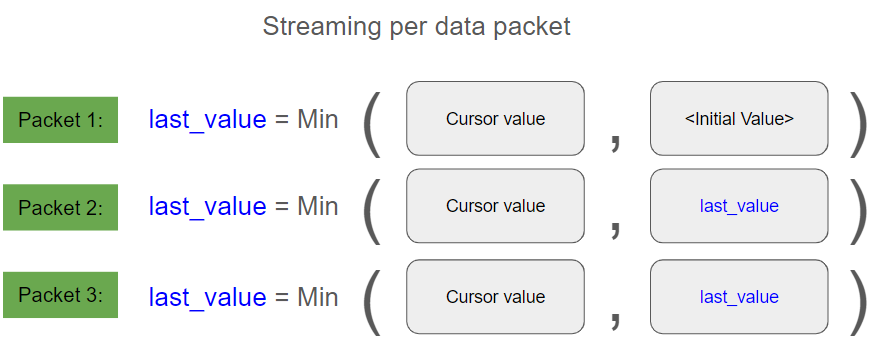

Let's create a function to process each single record from the source:

1. Start by setting the initial comparison value (`last_value`) with the first row and an `initial_value`.
  - The default `initial_value` is `"2050-01-01T00:00:00Z"`, this is set to a high value so that the "min" will always be the current item, in case the `last_value` is ever `None`.
2. As each row is loaded, compare its cursor value with the current `last_value` and update `last_value` to the smaller of the two. Hence mimicing the **min** functionality.



In [ ]:
def custom_last_value_func(event):
    last_value = None

    logger.info("Items received in this event: "+str(len(event)))

    if len(event) == 1:
        item, = event
    else:
        item, last_value = event

    logger.info("item['created_at']: "+str(item["created_at"])+" last value: "+str('None' if last_value is None else last_value))

    if last_value is None:
        last_value = {}
    elif type(last_value) != dict:
        last_value = {"created_at": last_value}

    # setting the
    last_value["created_at"] = min(item["created_at"], last_value.get("created_at", "2050-01-01T00:00:00Z"))

    logger.info("Final chosen last value: "+str(last_value['created_at'])+"\n")

    return last_value

If you pay attention to the logger output, you will see the default values of cursor values too!

Like this:
```
Bind incremental on get_issues with initial_value: 1970-01-01T00:00:00Z, start_value: 1970-01-01T00:00:00Z, end_value: None
```

In [ ]:
load_info = pipeline.run(
    get_issues(
        created_at=dlt.sources.incremental(
            "$",
            last_value_func=custom_last_value_func
        )
    )
)

print(load_info)

2024-08-22 08:50:05,848|[INFO]|679|139661715963904|dlt|__init__.py|bind:425|Bind incremental on get_issues with initial_value: None, start_value: None, end_value: None
2024-08-22 08:50:06,206|[INFO]|679|139661715963904|dlt|<ipython-input-6-84d1e24d8b91>|custom_last_value_func:3|Items received in this event: 1
2024-08-22 08:50:06,211|[INFO]|679|139661715963904|dlt|<ipython-input-6-84d1e24d8b91>|custom_last_value_func:8|item['created_at']: 2024-08-22T08:49:37Z last value: None
2024-08-22 08:50:06,215|[INFO]|679|139661715963904|dlt|<ipython-input-6-84d1e24d8b91>|custom_last_value_func:17|Final chosen last value: 2024-08-22T08:49:37Z

2024-08-22 08:50:06,217|[INFO]|679|139661715963904|dlt|<ipython-input-6-84d1e24d8b91>|custom_last_value_func:3|Items received in this event: 2
2024-08-22 08:50:06,220|[INFO]|679|139661715963904|dlt|<ipython-input-6-84d1e24d8b91>|custom_last_value_func:8|item['created_at']: 2024-08-22T08:48:41Z last value: {'created_at': '2024-08-22T08:49:37Z'}
2024-08-22 08:5

Pipeline github_issues_merge load step completed in 3.80 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data_merge
The duckdb destination used duckdb:////content/github_issues_merge.duckdb location to store data
Load package 1724316605.817306 is LOADED and contains no failed jobs


Let's check out the data again

In [ ]:
import duckdb

conn = duckdb.connect(f'{pipeline.pipeline_name}.duckdb')
dates = conn.sql('select * from github_data_merge.issues').df()['created_at']

max(dates), min(dates)

(Timestamp('2024-08-22 08:49:37+0000', tz='Etc/UTC'),
 Timestamp('2022-06-15 12:02:51+0000', tz='Etc/UTC'))

The data has been filled for the past. Let's see what is stored as the "last value" after this run:

In [ ]:
# reading the logs to see what dlt saved as the last value:

with open("dlt.log", "r") as f:
    for line in f.readlines()[-1:0:-1]:
        if line.startswith("Final chosen last value:"):
            print(line)
            break

Final chosen last value: 2022-06-15T13:14:43Z



# Using the `end_value` for backfill

Say, that now we only want data up from the last half of 2023 only. We utilize the initial_value `end_value` argument.

In [ ]:
# let's create another dataset for this otherwise, we'll have to change the write disposition to replace in the table
# we will essentially be deleting data but we don't want to disturb our merge-write disposition incremental loading pipeline

pipeline2 = dlt.pipeline(
    pipeline_name="github_issues_backfill",
    destination="duckdb",
    dataset_name="github_data_merge",
)

In [ ]:
# Using write disposition "replace" so that we can erase old data and load from the source again

load_info = pipeline2.run(
    get_issues(
        created_at=dlt.sources.incremental(
            "created_at",
            initial_value="2023-07-01T00:00:00Z",
            end_value="2024-01-01T00:00:00Z"
        )
    )
)

print(load_info)

2024-08-22 08:50:17,158|[INFO]|679|139661715963904|dlt|__init__.py|bind:425|Bind incremental on get_issues with initial_value: 2023-07-01T00:00:00Z, start_value: 2023-07-01T00:00:00Z, end_value: 2024-01-01T00:00:00Z
2024-08-22 08:50:18,193|[INFO]|679|139661715963904|dlt|pool_runner.py|run_pool:75|Created none pool with 1 workers
2024-08-22 08:50:18,197|[INFO]|679|139661715963904|dlt|normalize.py|run:263|Running file normalizing
2024-08-22 08:50:18,199|[INFO]|679|139661715963904|dlt|normalize.py|run:266|Found 1 load packages
2024-08-22 08:50:18,231|[INFO]|679|139661715963904|dlt|normalize.py|run:289|Found 2 files in schema github_issues_backfill load_id 1724316617.1227677
2024-08-22 08:50:18,237|[INFO]|679|139661715963904|dlt|normalize.py|spool_schema_files:240|Created new load package 1724316617.1227677 on loading volume
2024-08-22 08:50:18,250|[INFO]|679|139661715963904|dlt|worker.py|_get_items_normalizer:134|A file format for table _dlt_pipeline_state was specified to preferred in th

Pipeline github_issues_backfill load step completed in 2.68 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data_merge
The duckdb destination used duckdb:////content/github_issues_backfill.duckdb location to store data
Load package 1724316617.1227677 is LOADED and contains no failed jobs


Let's look at the data again, specifically to see from when the issues were loaded

In [ ]:
conn2 = duckdb.connect('github_issues_backfill.duckdb')
dates1 = conn2.sql('select * from github_data_merge.issues').df()['created_at']

max(dates1), min(dates1)

(Timestamp('2023-12-23 13:14:49+0000', tz='Etc/UTC'),
 Timestamp('2023-07-18 15:15:16+0000', tz='Etc/UTC'))

**You can use this either backfill your data, or to load your data in chunks** 😉

## Optimize backfill

With the `row_order` argument, `dlt` will stop getting data from the data source (ie. Github API) if it detects that values of that cursor field are out of range of `start` and `end` values.

The following code is a more optimized version of the previous pipeline run:

In [ ]:
# Using write disposition "replace" for this one so that we can erase old data and load from the source again

load_info = pipeline2.run(
    get_issues(
        created_at=dlt.sources.incremental(
            "created_at",
            initial_value="2023-07-01T00:00:00Z",
            end_value="2024-01-01T00:00:00Z",
            row_order="asc"
        )
    ),
    write_disposition="replace"
)

print(load_info)

dates1 = conn2.sql('SELECT * FROM github_data_merge.issues').df()['created_at']

print(max(dates1), min(dates1))

2024-08-22 08:50:21,868|[INFO]|679|139661715963904|dlt|__init__.py|bind:425|Bind incremental on get_issues with initial_value: 2023-07-01T00:00:00Z, start_value: 2023-07-01T00:00:00Z, end_value: 2024-01-01T00:00:00Z
2024-08-22 08:50:22,291|[INFO]|679|139661715963904|dlt|pool_runner.py|run_pool:75|Created none pool with 1 workers
2024-08-22 08:50:22,293|[INFO]|679|139661715963904|dlt|normalize.py|run:263|Running file normalizing
2024-08-22 08:50:22,295|[INFO]|679|139661715963904|dlt|normalize.py|run:266|Found 1 load packages
2024-08-22 08:50:22,374|[INFO]|679|139661715963904|dlt|normalize.py|run:289|Found 2 files in schema github_issues_backfill load_id 1724316621.850102
2024-08-22 08:50:22,382|[INFO]|679|139661715963904|dlt|normalize.py|spool_schema_files:240|Created new load package 1724316621.850102 on loading volume
2024-08-22 08:50:22,392|[INFO]|679|139661715963904|dlt|worker.py|_get_items_normalizer:134|A file format for table _dlt_pipeline_state was specified to preferred in the 

Pipeline github_issues_backfill load step completed in 1.32 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data_merge
The duckdb destination used duckdb:////content/github_issues_backfill.duckdb location to store data
Load package 1724316621.850102 is LOADED and contains no failed jobs


(Timestamp('2023-12-23 13:14:49+0000', tz='Etc/UTC'),
 Timestamp('2023-07-18 15:15:16+0000', tz='Etc/UTC'))

# Using Pipeline state

## [Refresher]

The pipeline state is a Python dictionary which lives alongside your data; you can store values in it and, on next pipeline run, request them back.

## Preserving the last value in resource state

In [ ]:
import json

def read_state(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
        pretty_json = json.dumps(data, indent=4)
        return pretty_json, data

In [ ]:
# lets first read what is already in the state -> the "last value already exists"
_, pipeline_state = read_state("/var/dlt/pipelines/github_issues_merge/state.json")

pipeline_state['sources']['github_issues_merge']['resources']['get_issues']['incremental']['$']['last_value']

{'created_at': '2022-06-15T12:02:51Z'}

This date sounds familiar -> it is exactly what we had the last time we checked our logs!

### Let's use the preserved state to load data

Let's do this in a separate table

In [ ]:
@dlt.resource(
    table_name="issues_state",
    write_disposition="merge",
    primary_key="id",
)
def get_issues_with_state():
    # use stored state to load data
    last_val = dlt.current.source_state().get('resources').get('get_issues').get('incremental').get('$').get('last_value').get('created_at')
    logger.info('value from state: '+str(last_val))


    url = (
        f"{BASE_URL}?since={last_val}&per_page=100&sort=updated"
        "&directions=desc&state=open"
    )
    yield pagination(url)

In [ ]:
info = pipeline.run(get_issues_with_state)

2024-08-22 08:50:24,626|[INFO]|679|139661715963904|dlt|<ipython-input-16-427e3adbc33c>|get_issues_with_state:9|value from state: 2022-06-15T12:02:51Z
2024-08-22 08:50:25,647|[INFO]|679|139661715963904|dlt|pool_runner.py|run_pool:75|Created none pool with 1 workers
2024-08-22 08:50:25,650|[INFO]|679|139661715963904|dlt|normalize.py|run:263|Running file normalizing
2024-08-22 08:50:25,653|[INFO]|679|139661715963904|dlt|normalize.py|run:266|Found 1 load packages
2024-08-22 08:50:25,754|[INFO]|679|139661715963904|dlt|normalize.py|run:289|Found 1 files in schema github_issues_merge load_id 1724316624.5922055
2024-08-22 08:50:25,758|[INFO]|679|139661715963904|dlt|normalize.py|spool_schema_files:240|Created new load package 1724316624.5922055 on loading volume
2024-08-22 08:50:25,767|[INFO]|679|139661715963904|dlt|worker.py|_get_items_normalizer:180|Created items normalizer JsonLItemsNormalizer with writer InsertValuesWriter for item format object and file format insert_values
2024-08-22 08:5

In [ ]:
dates = conn.sql('select * from github_data_merge.issues_state').df()['created_at']

max(dates), min(dates) # the min value is a month older than the one we got in the last step.

(Timestamp('2024-08-22 08:49:37+0000', tz='Etc/UTC'),
 Timestamp('2022-06-15 12:02:51+0000', tz='Etc/UTC'))

# Using the `last_value_func` field for lookback

Let's write a function for lookback into the past month using the `last_value_func` and **pipeline state**

In [ ]:
import pendulum

def custom_last_value_func_last_month(event):
    last_value = dlt.current.resource_state().get('incremental').get('$')

    if last_value.get("last_value") is None:
      last_value.update({"last_value": pendulum.parse("1970-01-01T00:00:00Z")})

    item = event[0]

    logger.info("To compare, item vs state: "+str(item["created_at"])+" vs "+str(last_value.get("last_value", pendulum.parse("1970-01-01T00:00:00Z"))))

    new_last_value = max(pendulum.parse(item["created_at"]).subtract(months=1),
                        last_value.get("last_value", pendulum.parse("1970-01-01T00:00:00Z"))
                        )

    if new_last_value != last_value.get('last_value'):
      last_value.update({"last_value": new_last_value})

    logger.info("Final chosen last value: "+str(new_last_value))

    return new_last_value

In [ ]:
load_info = pipeline.run(
    get_issues(
        created_at=dlt.sources.incremental(
            "$",
            last_value_func=custom_last_value_func_last_month
        )
    ),
    write_disposition="replace"
)

print(load_info)


2024-08-22 08:50:29,513|[INFO]|679|139661715963904|dlt|__init__.py|bind:425|Bind incremental on get_issues with initial_value: None, start_value: None, end_value: None
2024-08-22 08:50:29,852|[INFO]|679|139661715963904|dlt|<ipython-input-19-5db18c6464b5>|custom_last_value_func_last_month:11|To compare, item vs state: 2024-08-22T08:49:37Z vs 1970-01-01 00:00:00+00:00
2024-08-22 08:50:29,856|[INFO]|679|139661715963904|dlt|<ipython-input-19-5db18c6464b5>|custom_last_value_func_last_month:19|Final chosen last value: 2024-07-22 08:49:37+00:00
2024-08-22 08:50:29,859|[INFO]|679|139661715963904|dlt|<ipython-input-19-5db18c6464b5>|custom_last_value_func_last_month:11|To compare, item vs state: 2024-08-22T08:48:41Z vs 2024-07-22 08:49:37+00:00
2024-08-22 08:50:29,861|[INFO]|679|139661715963904|dlt|<ipython-input-19-5db18c6464b5>|custom_last_value_func_last_month:19|Final chosen last value: 2024-07-22 08:49:37+00:00
2024-08-22 08:50:29,863|[INFO]|679|139661715963904|dlt|<ipython-input-19-5db18c6

Pipeline github_issues_merge load step completed in 2.52 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data_merge
The duckdb destination used duckdb:////content/github_issues_merge.duckdb location to store data
Load package 1724316629.4879858 is LOADED and contains no failed jobs


In [ ]:
dates = conn.sql('select * from github_data_merge.issues').df()['created_at']

max(dates), min(dates)

(Timestamp('2024-08-22 08:49:37+0000', tz='Etc/UTC'),
 Timestamp('2022-06-15 12:02:51+0000', tz='Etc/UTC'))

In [ ]:
# reading the logs to see what dlt saved as the last value:

with open("dlt.log", "r") as f:
    for line in f.readlines()[-1:0:-1]:
        if line.startswith("Final chosen last value:"):
            print(line)
            break

Final chosen last value: 2024-07-22 08:49:37+00:00



In [ ]:
# lets first read what is already in the state -> the "last value already exists"
_, pipeline_state = read_state("/var/dlt/pipelines/github_issues_merge/state.json")

pipeline_state['sources']['github_issues_merge']['resources']['get_issues']['incremental']['$']['last_value']

'\uf0272024-07-22T08:49:37+00:00'

The date saved in state is exactly 1 month earlier than the last created record in the data!